# Exercises

1. Why would you want to use the tf.data API?
> Ingesting a large dataset and preprocessing it efficiently can be a complex engineering challenge. The Data API makes it fairly simple. It offers many features, including loading data from various sources (such as text or binary files), reading data in parallel from multiple sources, transforming it, interleaving the records, shuffling the data, batching it, and prefetching it.

2. What are the benefits of splitting a large dataset into multiple files?
> Splitting a large dataset into multiple files makes it possible to shuffle it at a coarse level before shuffling it at a finer level using a shuffling buffer. It also makes it possible to handle huge datasets that do not fit on a single machine. It's also simpler to manipulate thousands of small files rather than one huge file; for example, it's easier to split the data into multiple subsets. Lastly, if the data is split across multiple files spread across multiple servers, it is possible to download several files from different servers simultaneously, which improves the bandwidth usage.

3. During training, how can you tell that your input pipeline is the
bottleneck? What can you do to fix it?
> You can use TensorBoard to visualize profiling data: if the GPU is not fully utilized then your input pipeline is likely to be the bottleneck. You can fix it by making sure it reads and preprocesses the data in multiple threads in parallel, and ensuring it prefetches a few batches. If this is insufficient to get your GPU to 100% usage during training, make sure your preprocessing code is optimized. You can also try saving the dataset into multiple TFRecord files, and if necessary perform some of the preprocessing ahead of time so that it does not need to be done on the fly during training (TF Transform can help with this). If necessary, use a machine with more CPU and RAM, and ensure that the GPU bandwidth is large enough.

4. Can you save any binary data to a TFRecord file, or only serialized
protocol buffers?
> A TFRecord file is composed of a sequence of arbitrary binary records: you can store absolutely any binary data you want in each record. However, in practice most TFRecord files contain sequences of serialized protocol buffers. This makes it possible to benefit from the advantages of protocol buffers, such as the fact that they can be read easily across multiple platforms and languages and their definition can be updated later in a backward-compatible way.

5. Why would you go through the hassle of converting all your data to
the Example protobuf format? Why not use your own protobuf
definition?
> The Example protobuf format has the advantage that TensorFlow provides some operations to parse it (the tf.io.parse*example() functions) without you having to define your own format. It is sufficiently flexible to represent instances in most datasets. However, if it does not cover your use case, you can define your own protocol buffer, compile it using protoc (setting the --descriptor_set_out and --include_imports arguments to export the protobuf descriptor), and use the tf.io.decode_proto() function to parse the serialized protobufs (see the "Custom protobuf" section of the notebook for an example). It's more complicated, and it requires deploying the descriptor along with the model, but it can be done.

6. When using TFRecords, when would you want to activate
compression? Why not do it systematically?
> When using TFRecords, you will generally want to activate compression if the TFRecord files will need to be downloaded by the training script, as compression will make files smaller and thus reduce download time. But if the files are located on the same machine as the training script, it's usually preferable to leave compression off, to avoid wasting CPU for decompression.

7. Data can be preprocessed directly when writing the data files, or
within the tf.data pipeline, or in preprocessing layers within your
model. Can you list a few pros and cons of each option?
> Let's look at the pros and cons of each preprocessing option:

    * If you preprocess the data when creating the data files, the training script will run faster, since it will not have to perform preprocessing on the fly. In some cases, the preprocessed data will also be much smaller than the original data, so you can save some space and speed up downloads. It may also be helpful to materialize the preprocessed data, for example to inspect it or archive it. However, this approach has a few cons. First, it's not easy to experiment with various preprocessing logics if you need to generate a preprocessed dataset for each variant. Second, if you want to perform data augmentation, you have to materialize many variants of your dataset, which will use a large amount of disk space and take a lot of time to generate. Lastly, the trained model will expect preprocessed data, so you will have to add preprocessing code in your application before it calls the model. There's a risk of code duplication and preprocessing mismatch in this case.

    * If the data is preprocessed with the tf.data pipeline, it's much easier to tweak the preprocessing logic and apply data augmentation. Also, tf.data makes it easy to build highly efficient preprocessing pipelines (e.g., with multithreading and prefetching). However, preprocessing the data this way will slow down training. Moreover, each training instance will be preprocessed once per epoch rather than just once if the data was preprocessed when creating the data files. Well, unless the dataset fits in RAM and you can cache it using the dataset's `cache()` method. Lastly, the trained model will still expect preprocessed data. But if you use preprocessing layers in your tf.data pipeline to handle the preprocessing step, then you can just reuse these layers in your final model (adding them after training), to avoid code duplication and preprocessing mismatch.

    * If you add preprocessing layers to your model, you will only have to write the preprocessing code once for both training and inference. If your model needs to be deployed to many different platforms, you will not need to write the preprocessing code multiple times. Plus, you will not run the risk of using the wrong preprocessing logic for your model, since it will be part of the model. On the downside, preprocessing the data on the fly during training will slow things down, and each instance will be preprocessed once per epoch.
8. Name a few common ways you can encode categorical integer
features. What about text?

> Let's look at how to encode categorical text features and text:
    
    * To encode a categorical feature that has a natural order, such as a movie rating (e.g., "bad," "average," "good"), the simplest option is to use ordinal encoding: sort the categories in their natural order and map each category to its rank (e.g., "bad" maps to 0, "average" maps to 1, and "good" maps to 2). However, most categorical features don't have such a natural order. For example, there's no natural order for professions or countries. In this case, you can use one-hot encoding, or embeddings if there are many categories. With Keras, the `StringLookup` layer can be used for ordinal encoding (using the default `output_mode="int"`), or one-hot encoding (using `output_mode="one_hot"`). It can also perform multi-hot encoding (using `output_mode="multi_hot"`) if you want to encode multiple categorical text features together, assuming they share the same categories and it doesn't matter which feature contributed which category. For trainable embeddings, you must first use the `StringLookup` layer to produce an ordinal encoding, then use the `Embedding` layer.
    
    * For text, the `TextVectorization` layer is easy to use and it can work well for simple tasks, or you can use TF Text for more advanced features. However, you'll often want to use pretrained language models, which you can obtain using tools like TF Hub or Hugging Face's Transformers library. These last two options are discussed in Chapter 16.


## 9.
### a.
_Exercise: Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized `Example` protobuf with two features: the serialized image (use `tf.io.serialize_tensor()` to serialize each image), and the label. Note: for large images, you could use `tf.io.encode_jpeg()` instead. This would save a lot of space, but it would lose a bit of image quality._

In [1]:
import tensorflow as tf

(X_train_full,y_train_full),(X_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_valid,X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000],y_train_full[5000:]

In [3]:
tf.random.set_seed(42)
train_set = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_set = train_set.shuffle(len(X_train),seed=42)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid,y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test,y_test))


In [4]:
from tensorflow.train import Int64List,BytesList,Example,Feature,Features

def create_example(image,label):
    image_data = tf.io.serialize_tensor(image)
    return Example(
        features = Features(
            feature = {
                "image":Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }
        )
    )

In [5]:
for image, label in valid_set.take(1):
    print(create_example(image,label))

features {
  feature {
    key: "label"
    value {
      int64_list {
        value: 9
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\0

The following function saves a given dataset to a set of TFRecord files. The examples are written to the files in a round-robin fashion. To do this, we enumerate all the examples using the dataset.enumerate() method, and we compute index % n_shards to decide which file to write to. We use the standard contextlib.ExitStack class to make sure that all writers are properly closed whether or not an I/O error occurs while writing.

In [6]:
from contextlib import ExitStack

def write_tfrecords(name,dataset,n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name,index,n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index,(image,label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image,label)
            writers[shard].write(example.SerializeToString())
        return paths


In [7]:
train_filepaths = write_tfrecords("my_fashion_mnist.train",train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid",valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test",test_set)


### b.
_Exercise: Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data._

In [8]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([],tf.string,default_value=""),
        "label": tf.io.FixedLenFeature([],tf.int64,default_value=-1)
    }

    example = tf.io.parse_single_example(tfrecord,feature_descriptions)
    image = tf.io.parse_tensor(example["image"],out_type=tf.uint8)
    #image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image,shape=[28,28])
    return image, example["label"]

def mnist_dataset(filepaths,n_read_threads=5,shuffle_buffer_size=None,
                  n_parse_threads=5,batch_size=32,cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,num_parallel_reads=n_read_threads)

    if cache:
        dataset = dataset.cache()

    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess,num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)



In [9]:
train_set = mnist_dataset(train_filepaths,shuffle_buffer_size=60_000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)


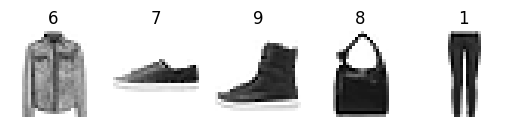

In [10]:
import matplotlib.pyplot as plt
import numpy as np
for X,y in train_set.take(1):
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(X[i].numpy(),cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))


In [12]:
tf.random.set_seed(42)

standardization = tf.keras.layers.Normalization(input_shape=[28,28])

sample_image_batches = train_set.take(100).map(lambda image,label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
axis=0).astype(np.float32)

standardization.adapt(sample_images)

model = tf.keras.Sequential([
    standardization,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(10,activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

In [13]:
from datetime import datetime
from pathlib import Path
logs = Path() / "my_logs" / "run_" / datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir = logs, histogram_freq = 1, profile_batch=10
)

model.fit(train_set,epochs=5,
          validation_data=valid_set,
          callbacks=[tensorboard_cb])

Epoch 1/5
   1715/Unknown 9s 4ms/step - accuracy: 0.8037 - loss: 0.5563

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8038 - loss: 0.5559 - val_accuracy: 0.8722 - val_loss: 0.3631
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8787 - loss: 0.3336 - val_accuracy: 0.8758 - val_loss: 0.3442
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8892 - loss: 0.2968 - val_accuracy: 0.8782 - val_loss: 0.3401
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8966 - loss: 0.2741 - val_accuracy: 0.8828 - val_loss: 0.3194
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9089 - loss: 0.2454 - val_accuracy: 0.8876 - val_loss: 0.3304


In [15]:
from tensorboard import notebook

notebook.start("--logdir=./my_logs")

Reusing TensorBoard on port 6006 (pid 4732), started 0:02:57 ago. (Use '!kill 4732' to kill it.)

In [19]:
# check if process is running
!tasklist | findstr tensorboard

tensorboard.exe              32004 Console                   16     10,440 K


In [21]:
!taskkill /PID 32004 /F

SUCCESS: The process with PID 32004 has been terminated.


10. In this exercise you will download a dataset, split it, create a
tf.data.Dataset to load it and preprocess it efficiently, then build
and train a binary classification model containing an Embedding layer:

### a.
_Exercise: Download the [Large Movie Review Dataset](https://homl.info/imdb), which contains 50,000 movies reviews from the [Internet Movie Database](https://imdb.com/). The data is organized in two directories, `train` and `test`, each containing a `pos` subdirectory with 12,500 positive reviews and a `neg` subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words), but we will ignore them in this exercise._

In [22]:
from pathlib import Path

root = "https://ai.stanford.edu/~amaas/data/sentiment/"
filename = "aclImdb_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,root+filename,extract=True,
                                   cache_dir=".")

if "_extracted" in filepath:
    path = Path(filepath) / "aclImdb"

else:
    path = Path(filepath).with_name("aclImdb")

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


In [25]:
# Let's define a tree() function to view the structure of the aclImdb directory:
def tree(path,level=0, indent=4,max_files=3):
    if level == 0:
        print(f"{path}/")
        level += 1
    sub_paths = sorted(path.iterdir())
    sub_dirs = [sub_path for sub_path in sub_paths if sub_path.is_dir()]
    filepaths = [sub_path for sub_path in sub_paths if not sub_path in sub_dirs]
    indent_str = " " * indent * level
    for sub_dir in sub_dirs:
        print(f"{indent_str}{sub_dir.name}/")
        tree(sub_dir,level + 1, indent)
    for filepath in filepaths[:max_files]:
        print(f"{indent_str}{filepath.name}")
    if len(filepaths) > max_files:
        print(f"{indent_str}...")

In [26]:
tree(path)

datasets\aclImdb_v1_extracted\aclImdb/
    test/
        neg/
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos/
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
    train/
        neg/
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos/
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup/
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
    imdb.vocab
    imdbEr.txt
    README


In [27]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)


(12500, 12500, 12500, 12500)

### b.
_Exercise: Split the test set into a validation set (15,000) and a test set (10,000)._

In [28]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

### c.
_Exercise: Use tf.data to create an efficient dataset for each set._

Since the dataset fits in memory, we can just load all the data using pure Python code and use `tf.data.Dataset.from_tensor_slices()`:

In [34]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath, encoding="utf-8") as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [35]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

tf.Tensor(b"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)

tf.Tensor(b"Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public a

In [36]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

1min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


It takes about 10mins seconds to load the dataset and go through it 10 times.

But let's pretend the dataset does not fit in memory, just to make things more interesting. Luckily, each review fits on just one line (they use <br /> to indicate line breaks), so we can read the reviews using a TextLineDataset. If they didn't we would have to preprocess the input files (e.g., converting them to TFRecords). For very large datasets, it would make sense to use a tool like Apache Beam for that.

In [37]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

In [38]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

2min 11s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Now it takes about 33 seconds to go through the dataset 10 times. That's much slower, essentially because the dataset is not cached in RAM, so it must be reloaded at each epoch. If you add .cache() just before .repeat(10), you will see that this implementation will be about as fast as the previous one.

In [39]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).cache().repeat(10): pass

48.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [40]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000, seed=42)
train_set = train_set.batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

### d.
_Exercise: Create a binary classification model, using a `TextVectorization` layer to preprocess each review._

Let's create a `TextVectorization` layer and adapt it to the full IMDB training set (if the training set did not fit in RAM, we could just use a smaller sample of the training set by calling `train_set.take(500)`). Let's use TF-IDF for now.

In [ ]:
max_tokens = 1000
sample_reviews = train_set.map(lambda review,label: review)
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode = "tf_idf"
)
text_vectorization.adapt(sample_reviews)

Good! Now let's take a look at the first 10 words in the vocabulary:

In [42]:
text_vectorization.get_vocabulary()[:10]

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']

These are the most common words in the reviews

We're ready to train the model!

In [43]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
    782/Unknown 9s 6ms/step - accuracy: 0.7675 - loss: 0.6374

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.7676 - loss: 0.6372 - val_accuracy: 0.8526 - val_loss: 0.3572
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8576 - loss: 0.3516 - val_accuracy: 0.8511 - val_loss: 0.3625
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8732 - loss: 0.3082 - val_accuracy: 0.8447 - val_loss: 0.3851
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8908 - loss: 0.2616 - val_accuracy: 0.8546 - val_loss: 0.3625
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9222 - loss: 0.2034 - val_accuracy: 0.8299 - val_loss: 0.4391


We get about 84.2% accuracy on the validation set after just the first epoch, but after that the model makes no significant progress. We will do better in Chapter 16. For now the point is just to perform efficient preprocessing using tf.data and Keras preprocessing layers.


### e.
_Exercise: Add an `Embedding` layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model._

To compute the mean embedding for each review, and multiply it by the square root of the number of words in that review, we will need a little function. For each sentence, this function needs to compute $M \times \sqrt N$, where $M$ is the mean of all the word embeddings in the sentence (excluding padding tokens), and $N$ is the number of words in the sentence (also excluding padding tokens). We can rewrite $M$ as $\dfrac{S}{N}$, where $S$ is the sum of all word embeddings (it does not matter whether or not we include the padding tokens in this sum, since their representation is a zero vector). So the function must return $M \times \sqrt N = \dfrac{S}{N} \times \sqrt N = \dfrac{S}{\sqrt N \times \sqrt N} \times \sqrt N= \dfrac{S}{\sqrt N}$.

In [44]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs,axis=-1)
    n_words = tf.math.count_nonzero(not_pad,axis=-1,keepdims=True)
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words,tf.float32))
    return tf.reduce_sum(inputs,axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])

compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

Let's check that this is correct. The first review contains 2 words (the last token is a zero vector, which represents the `<pad>` token). Let's compute the mean embedding for these 2 words, and multiply the result by the square root of 2:

In [45]:
tf.reduce_mean(another_example[0:1, :2], axis=1) * tf.sqrt(2.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3.535534 , 4.9497476, 2.1213202]], dtype=float32)>

Looks good! Now let's check the second review, which contains just one word (we ignore the two padding tokens):

In [46]:
tf.reduce_mean(another_example[1:2, :1], axis=1) * tf.sqrt(1.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6., 0., 0.]], dtype=float32)>

Perfect. Now we're ready to train our final model. It's the same as before, except we replaced TF-IDF with ordinal encoding (output_mode="int") followed by an Embedding layer, followed by a Lambda layer that calls the compute_mean_embedding layer:

In [47]:
embedding_size = 20
tf.random.set_seed(42)

text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="int")
text_vectorization.adapt(sample_reviews)

model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Embedding(input_dim=max_tokens,
                              output_dim=embedding_size,
                              mask_zero=True),  # <pad> tokens => zero vectors
    tf.keras.layers.Lambda(compute_mean_embedding),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

### f.
_Exercise: Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible._

In [48]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5



C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'lambda' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5716 - loss: 0.6729 - val_accuracy: 0.7181 - val_loss: 0.5333
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7430 - loss: 0.5154 - val_accuracy: 0.7135 - val_loss: 0.5113
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7924 - loss: 0.4429 - val_accuracy: 0.7475 - val_loss: 0.4935
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7978 - loss: 0.4422 - val_accuracy: 0.8176 - val_loss: 0.3903
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8156 - loss: 0.4092 - val_accuracy: 0.8501 - val_loss: 0.3539


The model is just marginally better using embeddings (but we will do better in Chapter 16). The pipeline looks fast enough (we optimized it earlier).

### g.

Exercise: Use TFDS to load the same dataset more easily: tfds.load("imdb_reviews").

In [3]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

ChunkedEncodingError: ("Connection broken: ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)", ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [ ]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])